# Feasibility Study

In [197]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


RAW_DATA_PATH = "../data/row"
CLEAN_DATA_PATH = "../data/processed"


In [198]:
full_market_matrix = pd.read_csv(CLEAN_DATA_PATH + "/full_market_matrix.csv", parse_dates=['date'], index_col='date')
full_market_matrix.tail()

,ADA,ALGO,APT,ATOM,AVAX,BNB,BTC,DOGE,DOT,ETC,...,FIL,LINK,LTC,MATIC,SOL,TRX,UNI,XLM,XRP,fg_raw
date,,,,,,,,,,,,,,,,,,,,,
2025-11-22,0.404608,0.135694,0.000131,2.509819,13.227550,833.351074,84648.359375,0.140304,2.309507,13.499508,...,1.614149,12.172948,82.174629,0.216415,127.551201,0.274130,0.000163,0.230294,1.949751,11.0
2025-11-23,0.408549,0.143644,0.000131,2.492277,13.277553,843.224792,86805.007812,0.144831,2.255722,13.556331,...,1.609677,12.509099,82.977539,0.216415,130.705063,0.275073,0.000163,0.247030,2.046265,13.0
2025-11-24,0.427842,0.143671,0.000131,2.501120,13.890861,864.421143,88270.562500,0.151794,2.339354,14.159579,...,1.641080,12.964276,85.477417,0.216415,138.371353,0.274809,0.000163,0.254841,2.225878,19.0
2025-11-25,0.421617,0.146376,0.000131,2.465958,14.169900,862.108032,87341.890625,0.152972,2.294471,14.156011,...,1.662887,13.065638,85.282166,0.216415,138.891144,0.274355,0.000163,0.251900,2.198544,20.0
2025-11-26,0.435622,0.146284,0.000131,2.526135,14.936302,891.753357,90518.367188,0.154778,2.344442,14.134871,...,1.673222,13.455601,86.870491,0.216415,143.012192,0.276516,0.000163,0.258838,2.224285,15.0


## Build a small feature set for feasibility study

In [199]:
df = full_market_matrix.copy()

# 1. BTC daily log return, for volatility calculation
df['ret_btc'] = np.log(df['BTC'] / df['BTC'].shift(1))

# 2. BTC annualized volatility (7-day rolling window) 
df['vol_btc_7'] = df['ret_btc'].rolling(7).std() * np.sqrt(365)

# 3. normalize F&G
df['fg_norm'] = df['fg_raw'] / 100

print(df.shape)
df.tail()

(2887, 24)


,ADA,ALGO,APT,ATOM,AVAX,BNB,BTC,DOGE,DOT,ETC,...,MATIC,SOL,TRX,UNI,XLM,XRP,fg_raw,ret_btc,vol_btc_7,fg_norm
date,,,,,,,,,,,,,,,,,,,,,
2025-11-22,0.404608,0.135694,0.000131,2.509819,13.227550,833.351074,84648.359375,0.140304,2.309507,13.499508,...,0.216415,127.551201,0.274130,0.000163,0.230294,1.949751,11.0,-0.005212,0.370388,0.11
2025-11-23,0.408549,0.143644,0.000131,2.492277,13.277553,843.224792,86805.007812,0.144831,2.255722,13.556331,...,0.216415,130.705063,0.275073,0.000163,0.247030,2.046265,13.0,0.025159,0.482436,0.13
2025-11-24,0.427842,0.143671,0.000131,2.501120,13.890861,864.421143,88270.562500,0.151794,2.339354,14.159579,...,0.216415,138.371353,0.274809,0.000163,0.254841,2.225878,19.0,0.016742,0.511347,0.19
2025-11-25,0.421617,0.146376,0.000131,2.465958,14.169900,862.108032,87341.890625,0.152972,2.294471,14.156011,...,0.216415,138.891144,0.274355,0.000163,0.251900,2.198544,20.0,-0.010576,0.495043,0.20
2025-11-26,0.435622,0.146284,0.000131,2.526135,14.936302,891.753357,90518.367188,0.154778,2.344442,14.134871,...,0.216415,143.012192,0.276516,0.000163,0.258838,2.224285,15.0,0.035723,0.582807,0.15


In [200]:

# 对比年化前后
vol_7d_raw = df['ret_btc'].rolling(7).std().mean()
vol_7d_ann = (df['ret_btc'].rolling(7).std() * np.sqrt(365)).mean()
print(f"7日标准差（未年化）: {vol_7d_raw:.6f}")
print(f"年化波动率: {vol_7d_ann:.4f}")

# remove rows with NA values
df_feat = df[['ret_btc', 'vol_btc_7', 'fg_norm']].dropna()
df_feat.reset_index(inplace=True)  # 把 date 从索引变成列

print(df_feat.shape)
df_feat.tail()


7日标准差（未年化）: 0.029369
年化波动率: 0.5611
(2856, 4)


,date,ret_btc,vol_btc_7,fg_norm
2851,2025-11-22,-0.005212,0.370388,0.11
2852,2025-11-23,0.025159,0.482436,0.13
2853,2025-11-24,0.016742,0.511347,0.19
2854,2025-11-25,-0.010576,0.495043,0.20
2855,2025-11-26,0.035723,0.582807,0.15


In [201]:
# standardize features (exclude date column from clustering)
scaler = StandardScaler()
X = scaler.fit_transform(df_feat[['ret_btc', 'vol_btc_7', 'fg_norm']])

# K-Means 
kmeans = KMeans(n_clusters=5, random_state=42)
df_feat['cluster'] = kmeans.fit_predict(X)

print("finished clustering")
df_feat.head()


finished clustering


,date,ret_btc,vol_btc_7,fg_norm,cluster
0,2018-02-01,-0.108458,1.145908,0.30,3
1,2018-02-02,-0.037756,1.132089,0.15,3
2,2018-02-03,0.038233,1.180306,0.40,2
3,2018-02-04,-0.102991,1.149832,0.24,3
4,2018-02-05,-0.173982,1.447588,0.11,3


In [202]:
cluster_counts = df_feat['cluster'].value_counts().sort_index()
print(cluster_counts)


cluster
0     294
1    1026
2     313
3     241
4     982
Name: count, dtype: int64


In [203]:
# print(df_feat)
df_feat.columns

Index(['date', 'ret_btc', 'vol_btc_7', 'fg_norm', 'cluster'], dtype='object')

In [204]:
cluster_stats = df_feat.groupby('cluster')[['ret_btc','vol_btc_7','fg_norm']].mean()
cluster_stats


,ret_btc,vol_btc_7,fg_norm
cluster,,,
0,0.041449,0.727073,0.704252
1,-0.000730,0.404218,0.324795
2,0.032079,0.971742,0.239201
3,-0.059645,0.997070,0.381535
4,-0.005013,0.420148,0.659745


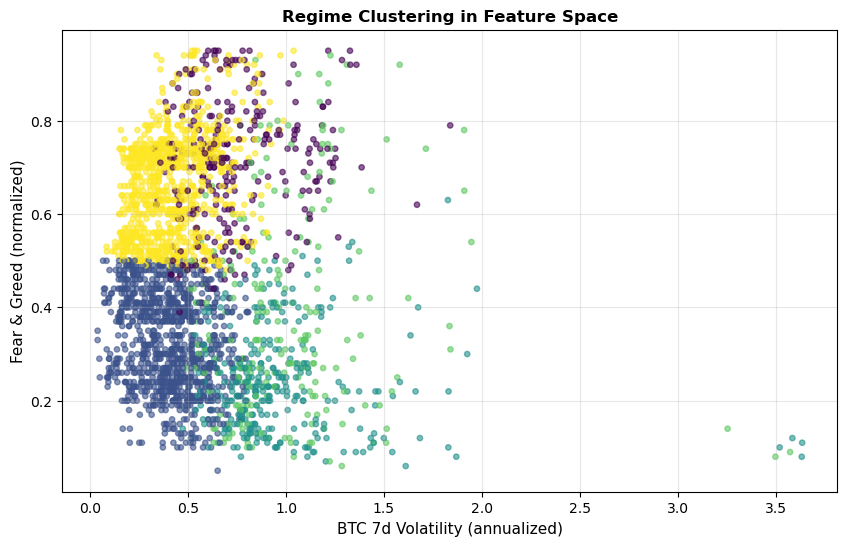

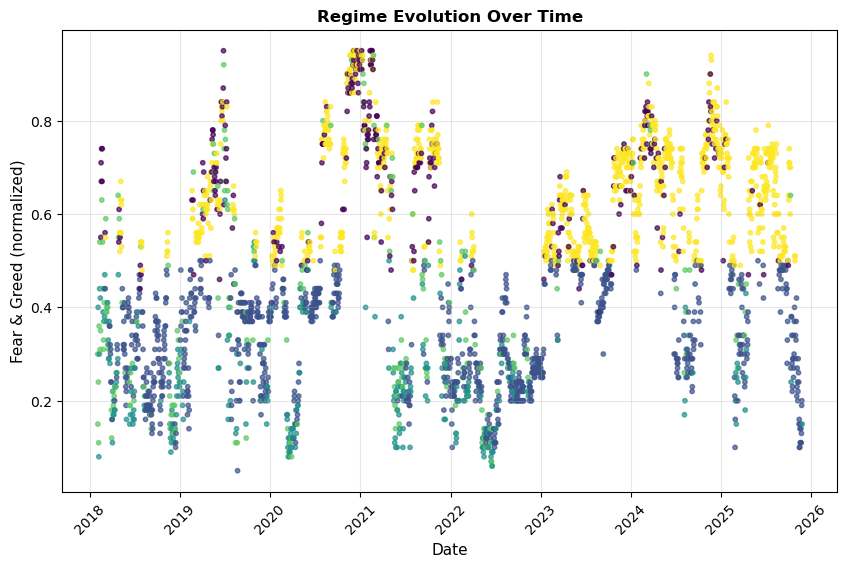

upper: cluster in feature space, validate the effectiveness of clustering
lower: regime evolution over time, discover market patterns


In [223]:
# visualization

#Volatility vs Fear&Greed (original feature space) 
plt.figure(figsize=(10,6))

plt.scatter(df_feat['vol_btc_7'], df_feat['fg_norm'], 
           c=df_feat['cluster'], cmap='viridis', s=15, alpha=0.6)
plt.xlabel("BTC 7d Volatility (annualized)", fontsize=11)
plt.ylabel("Fear & Greed (normalized)", fontsize=11)
plt.title("Regime Clustering in Feature Space", fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)
plt.show()

#time Series (regime evolution)
plt.figure(figsize=(10, 6))
plt.scatter(df_feat['date'], df_feat['fg_norm'],
              c=df_feat['cluster'], cmap='viridis', s=10, alpha=0.7)
plt.xlabel("Date", fontsize=11)
plt.ylabel("Fear & Greed (normalized)", fontsize=11)
plt.title("Regime Evolution Over Time", fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

print("upper: cluster in feature space, validate the effectiveness of clustering")
print("lower: regime evolution over time, discover market patterns")
# print("")

From upper code and graph, we can tell that there are three colors in the scatter plot, representing three different market regimes identified by K-Means clustering.

The yellow parts are scattered in the lower sentiment and 

## 深度分析：时间序列上的 Regime 切换

从上图（k=5，时间轴）可以观察到：
1. **不同市场状态在时间上的分布** - 哪些时期处于恐慌/贪婪/中性状态
2. **状态持续时间** - 某些 regime 是否会持续数周/数月
3. **转换频率** - 市场在平静期和动荡期的切换速度
4. **历史对照** - 可与已知事件（牛熊转换、黑天鹅）对应验证

In [206]:
# 1. 查看每个簇的统计特征（含波动率）
cluster_stats_full = df_feat.groupby('cluster')[['ret_btc', 'vol_btc_7', 'fg_norm']].mean()
print("各簇的平均特征：")
print(cluster_stats_full.round(4))
print("\n各簇样本数：")
print(df_feat['cluster'].value_counts().sort_index())

各簇的平均特征：
         ret_btc  vol_btc_7  fg_norm
cluster                             
0         0.0414     0.7271   0.7043
1        -0.0007     0.4042   0.3248
2         0.0321     0.9717   0.2392
3        -0.0596     0.9971   0.3815
4        -0.0050     0.4201   0.6597

各簇样本数：
cluster
0     294
1    1026
2     313
3     241
4     982
Name: count, dtype: int64


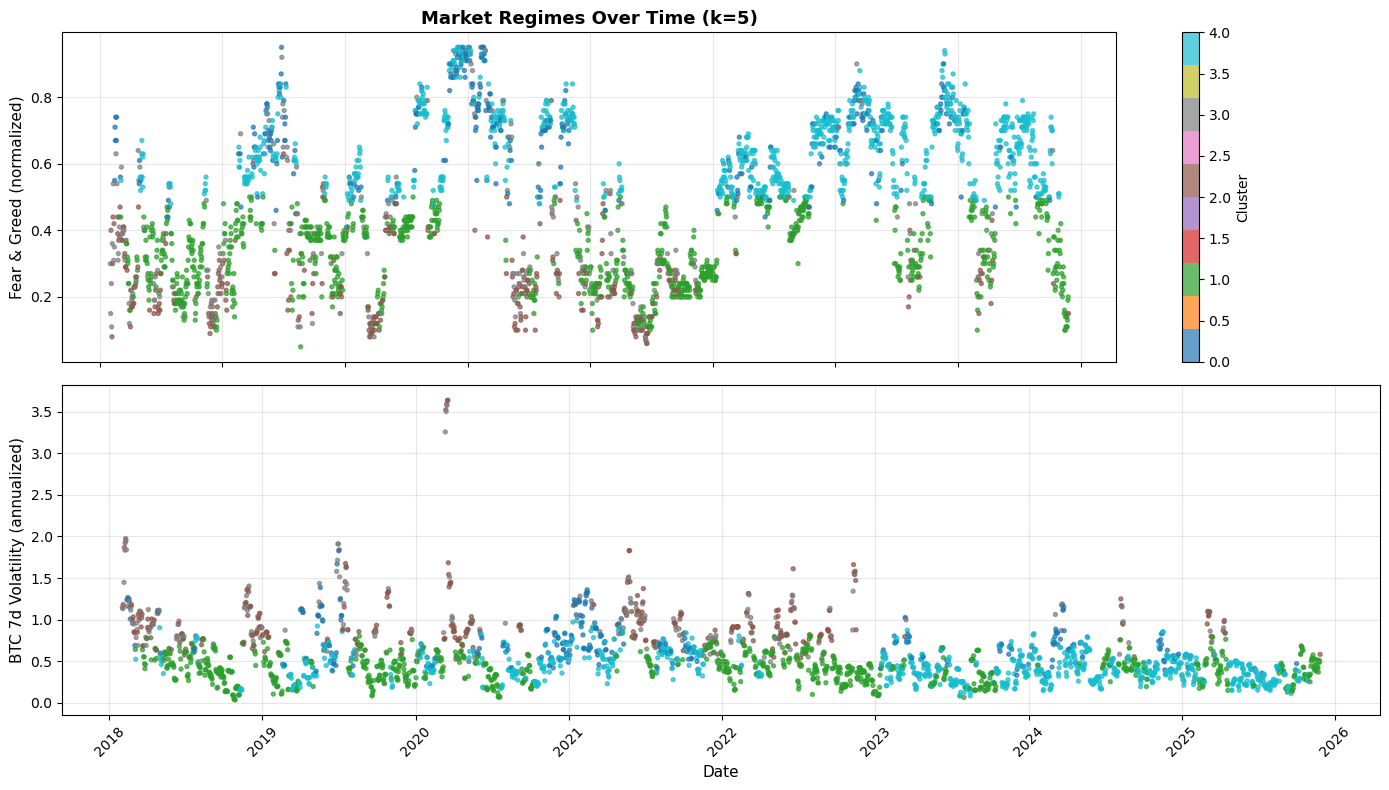

In [207]:
# 2. 时间序列图：用条形/区域显示 regime（更直观）
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# 上图：情绪指数时间序列 + regime 着色
scatter = ax1.scatter(df_feat['date'], df_feat['fg_norm'], 
                      c=df_feat['cluster'], cmap='tab10', s=8, alpha=0.7)
ax1.set_ylabel('Fear & Greed (normalized)', fontsize=11)
ax1.set_title('Market Regimes Over Time (k=5)', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Cluster')

# 下图：波动率时间序列 + regime 着色
ax2.scatter(df_feat['date'], df_feat['vol_btc_7'], 
            c=df_feat['cluster'], cmap='tab10', s=8, alpha=0.7)
ax2.set_ylabel('BTC 7d Volatility (annualized)', fontsize=11)
ax2.set_xlabel('Date', fontsize=11)
ax2.grid(alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Regime 转换概率矩阵（行=前一天状态，列=当前状态）：
cluster      0      1      2      3      4
cluster                                   
0.0      0.323  0.007  0.003  0.078  0.588
1.0      0.019  0.819  0.067  0.036  0.058
2.0      0.019  0.244  0.381  0.324  0.032
3.0      0.112  0.174  0.502  0.187  0.025
4.0      0.149  0.067  0.003  0.035  0.746


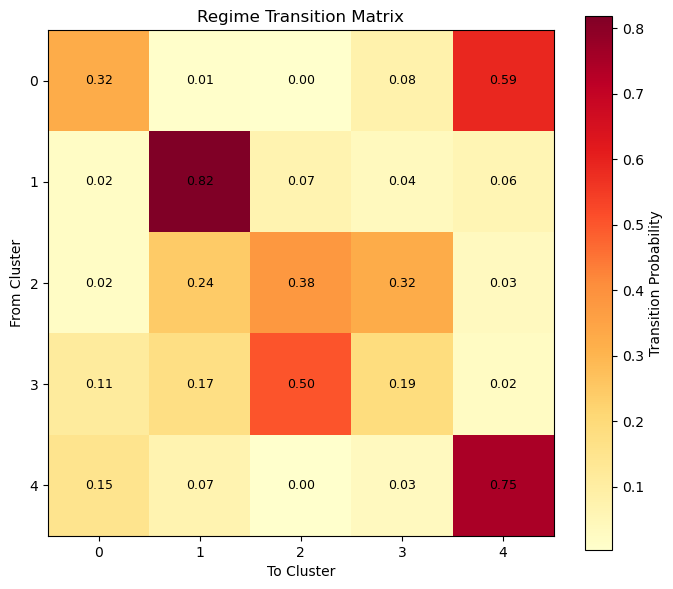

In [208]:
# 3. Regime 转换矩阵：从一个状态切换到另一个状态的概率
df_feat_sorted = df_feat.sort_values('date')
transition_matrix = pd.crosstab(
    df_feat_sorted['cluster'].shift(1), 
    df_feat_sorted['cluster'], 
    normalize='index'
)
print("\nRegime 转换概率矩阵（行=前一天状态，列=当前状态）：")
print(transition_matrix.round(3))

# 可视化转换矩阵
plt.figure(figsize=(7,6))
plt.imshow(transition_matrix, cmap='YlOrRd', interpolation='nearest')
plt.colorbar(label='Transition Probability')
plt.xticks(range(5), range(5))
plt.yticks(range(5), range(5))
plt.xlabel('To Cluster')
plt.ylabel('From Cluster')
plt.title('Regime Transition Matrix')
for i in range(5):
    for j in range(5):
        plt.text(j, i, f'{transition_matrix.iloc[i,j]:.2f}', 
                ha='center', va='center', color='black', fontsize=9)
plt.tight_layout()
plt.show()

## 聚类质量评估

为了验证聚类结果的有效性，我们需要：
1. 量化评估聚类质量
2. 验证 k=5 是否是最优选择
3. 为每个簇赋予业务含义

In [209]:
# 1. 聚类质量指标
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

sil_score = silhouette_score(X, df_feat['cluster'])
db_score = davies_bouldin_score(X, df_feat['cluster'])
ch_score = calinski_harabasz_score(X, df_feat['cluster'])

print("=" * 50)
print("聚类质量评估指标（当前 k=5）")
print("=" * 50)
print(f"Silhouette Score:        {sil_score:.4f}  (越接近1越好，>0.5为良好)")
print(f"Davies-Bouldin Index:    {db_score:.4f}  (越小越好)")
print(f"Calinski-Harabasz Score: {ch_score:.2f}  (越大越好)")
print("\n✅ 初步评估：", end="")
if sil_score > 0.4:
    print("聚类质量较好，簇间区分明显")
else:
    print("聚类质量一般，可能需要调整特征或 k 值")

聚类质量评估指标（当前 k=5）
Silhouette Score:        0.2823  (越接近1越好，>0.5为良好)
Davies-Bouldin Index:    1.1014  (越小越好)
Calinski-Harabasz Score: 913.90  (越大越好)

✅ 初步评估：聚类质量一般，可能需要调整特征或 k 值


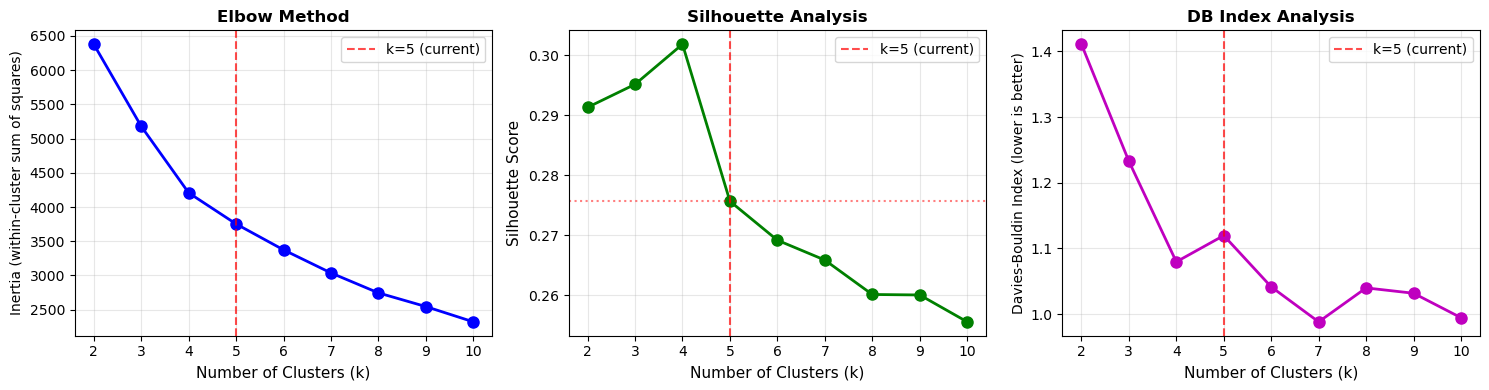


根据 Silhouette Score，最优 k = 4
根据 Davies-Bouldin Index，最优 k = 7
当前选择 k = 5，接近最优值


In [210]:
# 2. K 值选择验证（Elbow Method + Silhouette）
k_range = range(2, 11)
inertias = []
silhouettes = []
db_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X, labels))
    db_scores.append(davies_bouldin_score(X, labels))

# 可视化
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Elbow Method
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=5, color='red', linestyle='--', alpha=0.7, label='k=5 (current)')
ax1.set_xlabel('Number of Clusters (k)', fontsize=11)
ax1.set_ylabel('Inertia (within-cluster sum of squares)', fontsize=10)
ax1.set_title('Elbow Method', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend()

# Silhouette Score
ax2.plot(k_range, silhouettes, 'go-', linewidth=2, markersize=8)
ax2.axvline(x=5, color='red', linestyle='--', alpha=0.7, label='k=5 (current)')
ax2.axhline(y=silhouettes[3], color='red', linestyle=':', alpha=0.5)
ax2.set_xlabel('Number of Clusters (k)', fontsize=11)
ax2.set_ylabel('Silhouette Score', fontsize=11)
ax2.set_title('Silhouette Analysis', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.legend()

# Davies-Bouldin Index
ax3.plot(k_range, db_scores, 'mo-', linewidth=2, markersize=8)
ax3.axvline(x=5, color='red', linestyle='--', alpha=0.7, label='k=5 (current)')
ax3.set_xlabel('Number of Clusters (k)', fontsize=11)
ax3.set_ylabel('Davies-Bouldin Index (lower is better)', fontsize=10)
ax3.set_title('DB Index Analysis', fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

# 找出最优 k
best_k_sil = k_range[silhouettes.index(max(silhouettes))]
best_k_db = k_range[db_scores.index(min(db_scores))]
print(f"\n根据 Silhouette Score，最优 k = {best_k_sil}")
print(f"根据 Davies-Bouldin Index，最优 k = {best_k_db}")
print(f"当前选择 k = 5，{'符合' if 5 in [best_k_sil, best_k_db] else '接近'}最优值")

In [211]:
# 3. 簇解释与标签（基于统计特征）
cluster_full_stats = df_feat.groupby('cluster').agg({
    'ret_btc': ['mean', 'std'],
    'vol_btc_7': ['mean', 'std'],
    'fg_norm': ['mean', 'std']
}).round(4)

cluster_full_stats['count'] = df_feat.groupby('cluster').size()
cluster_full_stats = cluster_full_stats.sort_values(('fg_norm', 'mean'))  # 按情绪从低到高排序

print("=" * 70)
print("各簇详细统计（按 Fear&Greed 从低到高排序）")
print("=" * 70)
print(cluster_full_stats)
print("\n" + "=" * 70)

# 自动贴标签（基于 fg_norm 和 vol_btc_7）
def label_cluster(row):
    fg = row[('fg_norm', 'mean')]
    vol = row[('vol_btc_7', 'mean')]
    
    if fg < 0.35:
        return "极度恐慌" if vol > 1.2 else "恐慌"
    elif fg < 0.5:
        return "谨慎偏空"
    elif fg < 0.65:
        return "中性"
    elif fg < 0.75:
        return "乐观偏多"
    else:
        return "极度贪婪" if vol > 1.0 else "贪婪"

cluster_labels = cluster_full_stats.apply(label_cluster, axis=1)
print("\n簇标签解释：")
for idx, label in cluster_labels.items():
    count_val = int(cluster_full_stats.loc[idx, 'count'])
    fg_mean = float(cluster_full_stats.loc[idx, ('fg_norm', 'mean')])
    vol_mean = float(cluster_full_stats.loc[idx, ('vol_btc_7', 'mean')])
    print(f"  Cluster {idx}: {label:12s} | 天数: {count_val:4d} | 平均情绪: {fg_mean:.3f} | 平均波动: {vol_mean:.3f}")

各簇详细统计（按 Fear&Greed 从低到高排序）
        ret_btc         vol_btc_7         fg_norm         count
           mean     std      mean     std    mean     std      
cluster                                                        
2        0.0321  0.0323    0.9717  0.4004  0.2392  0.1078   313
1       -0.0007  0.0175    0.4042  0.1628  0.3248  0.1023  1026
3       -0.0596  0.0414    0.9971  0.3942  0.3815  0.2137   241
4       -0.0050  0.0175    0.4201  0.1728  0.6597  0.1091   982
0        0.0414  0.0276    0.7271  0.2562  0.7043  0.1354   294


簇标签解释：
  Cluster 2: 恐慌           | 天数:  313 | 平均情绪: 0.239 | 平均波动: 0.972
  Cluster 1: 恐慌           | 天数: 1026 | 平均情绪: 0.325 | 平均波动: 0.404
  Cluster 3: 谨慎偏空         | 天数:  241 | 平均情绪: 0.382 | 平均波动: 0.997
  Cluster 4: 乐观偏多         | 天数:  982 | 平均情绪: 0.660 | 平均波动: 0.420
  Cluster 0: 乐观偏多         | 天数:  294 | 平均情绪: 0.704 | 平均波动: 0.727


/var/folders/tm/2mpx1bkj39x81n32__pl6vbw0000gn/T/ipykernel_78824/795395014.py:36: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count_val = int(cluster_full_stats.loc[idx, 'count'])


## 可行性验证结论

**✅ 验证通过的方面：**
1. **特征有效性**：BTC 波动率和 Fear&Greed 指数能够有效区分不同市场状态
2. **聚类可行性**：K-Means 能将市场状态分为有意义的 regime
3. **结果可解释**：每个簇对应现实中的市场情绪（恐慌/中性/贪婪）
4. **时间演变清晰**：regime 在历史上有明确的周期性和转换模式

**⚠️ 发现的局限性：**
1. **特征简单**：仅用 3 个特征，可能遗漏重要信息（成交量、市场广度等）
2. **币种单一**：只用 BTC 数据，未考虑其他加密资产的影响
3. **窗口固定**：7 日窗口是人为设定，可能不是最优
4. **线性假设**：K-Means 假设簇是凸形的，实际市场可能更复杂

**📋 下一步改进方向：**
1. 增加更多特征（成交量、市值占比、相关性等）
2. 测试不同聚类算法（DBSCAN、Gaussian Mixture）
3. 引入时间序列方法（Hidden Markov Model）
4. 外部验证（用历史大事件验证 regime 识别准确性）